In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [2]:
loss = nn.CrossEntropyLoss()

input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5).softmax(dim=1)
output = loss(input, target)

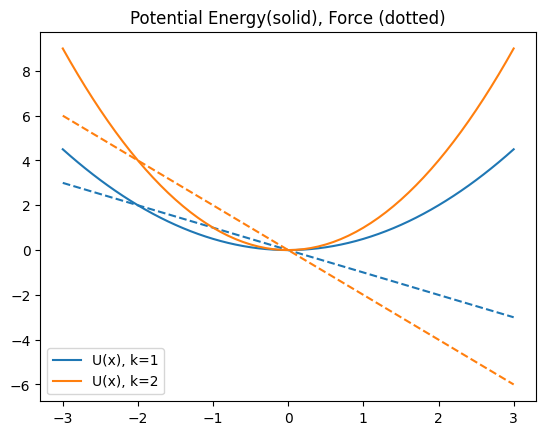

In [3]:
#this function returns the energy and force on a particle from a harmonic potential
def harmonic_oscillator_energy_force(x,k=1,x0=0):
    energy = 0.5*k*(x-x0)**2
    force = -k*(x-x0)
    return energy, force

#this function will plot the energy and force
#it is very general since it uses a special python trick of taking arbitrary named arguments (**kwargs) 
#and passes them on to a specified input function
def plot_energy_force(function, xmin=-3,xmax=3,spacing=0.1,**kwargs):
    x_points = np.arange(xmin,xmax+spacing,spacing)
    energies, forces = function(x_points,**kwargs)
    label = 'U(x)'
    for arg in kwargs:
        label=label+', %s=%s'%(arg,str(kwargs[arg]))
        p = plt.plot(x_points,energies,label=label)
        plt.plot(x_points,forces,label='',color=p[0].get_color(),linestyle='--')
        plt.legend(loc=0)
        plt.title("Potential Energy(solid), Force (dotted)")
        plt.savefig(str(function)+".png")
        
#we can plot the energy (solid) and forces (dashed) to see if it looks right
plot_energy_force(harmonic_oscillator_energy_force,k=1)
plot_energy_force(harmonic_oscillator_energy_force,k=2)

In [4]:
#this is step A
def position_update(x,v,dt):
    x_new = x + v*dt/2.
    return x_new


#this is step B
def velocity_update(v,F,dt):
    v_new = v + F*dt/2.
    return v_new

def random_velocity_update(v,gamma,kBT,dt):
    R = np.random.normal()
    c1 = np.exp(-gamma*dt)
    c2 = np.sqrt(1-c1*c1)*np.sqrt(kBT)
    v_new = c1*v + R*c2
    return v_new

def baoab(potential, max_time, dt, gamma, kBT, initial_position, initial_velocity,
                                        save_frequency=3, **kwargs ):
    x = initial_position
    v = initial_velocity
    t = 0
    step_number = 0
    positions = []
    velocities = []
    total_energies = []
    save_times = []
    
    while(t<max_time):
        # B
        potential_energy, force = potential(x,**kwargs)
        v = velocity_update(v,force,dt)
        # A
        x = position_update(x,v,dt)
        # O
        v = random_velocity_update(v,gamma,kBT,dt)
        # A
        x = position_update(x,v,dt)
        # B
        potential_energy, force = potential(x,**kwargs)
        v = velocity_update(v,force,dt)
        
        if step_number%save_frequency == 0 and step_number>0:
            e_total = .5*v*v + potential_energy

            positions.append(x)
            velocities.append(v)
            total_energies.append(e_total)
            save_times.append(t)
        
        t = t+dt
        step_number = step_number + 1
    
    return save_times, positions, velocities, total_energies   

(1333,)
(1333, 1)


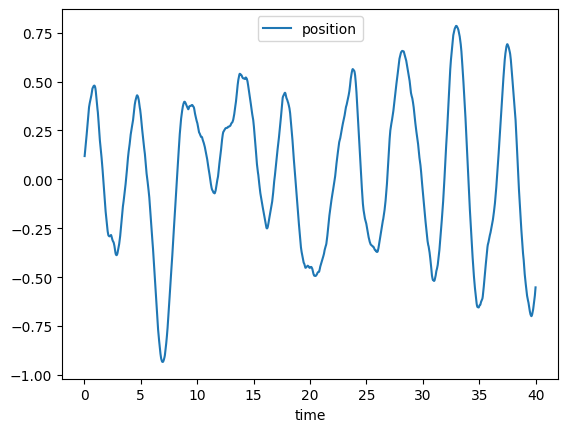

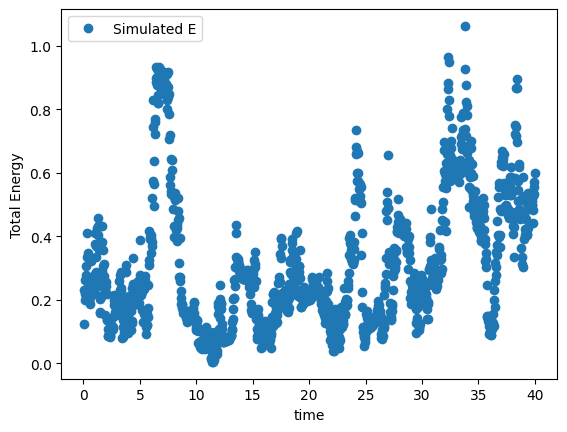

In [5]:
my_k = 2
my_max_time = 40
initial_position = .1
initial_velocity = .5

my_gamma=0.5
my_kBT=0.25
my_dt=0.01

times, positions, velocities, total_energies = baoab(
    harmonic_oscillator_energy_force,
    my_max_time, my_dt, my_gamma, my_kBT,
    initial_position, initial_velocity,
    k=my_k
)

plt.plot(times, positions, marker='', label='position', linestyle='-')

plt.xlabel('time')
plt.legend(loc='upper center')
plt.savefig("harm-v-x.png")
plt.figure()
plt.plot(times, total_energies, marker='o', linestyle='', label='Simulated E')
plt.xlabel('time')
plt.ylabel("Total Energy")
plt.legend()
plt.savefig("harm-e.png")

positions = np.array(positions)
print (np.shape(positions))

training_set = positions.reshape(positions.shape + (1,))
print (np.shape(training_set))


In [6]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append([_x]) # for now we have 1 channel (position)
        y.append(_y)

    return np.array(x), np.array(y)

In [7]:
seq_length = 64
x, y = sliding_windows(training_set.flatten(), seq_length)

data_x = torch.Tensor(np.array(x))
data_y = torch.Tensor(np.array(y))

In [8]:
data_x.shape

torch.Size([1268, 1, 64])

In [9]:
data_y.shape

torch.Size([1268])

In [10]:
def shuffle(data, new):
    """
        shuffle(data, new)
    Adds `new` to the end of `data`, moving the entries of `data` back by one
    position, and dropping the value at `data[0]`
    """
    n = data.shape[2]
    A = data.clone()
    B = data.clone()
    A[0, 0, :n-1] = B[0, 0, 1:]
    A[0, 0,  n-1] = new
    return A.clone()

def sample(data, a, b):
    """
        sample(data, a, b)
    Returns a random sample between `a`, and `b` using the probabilities given
    in `data`
    """
    return np.random.choice(
        np.arange(a, b, (b-a)/data.shape[1]), 1, p=data[0,:]
    )

In [11]:
def get_minmax(data):
    """
        get_minmax(data)
    Returns the min and max of `data`
    """
    return torch.min(data), torch.max(data)

def generate_distribution(y, a, b, n, sigma):
    """
        generate_distribution(y, a, b, n, sigma)
    Returns a histogram of `n` bins between `a` and `b` whose weights are
    distributed according to a Gaussian probability density with mean `y` and
    standard deviation `sigma`
    """
    dx  = (b - a) / (n - 1)
    idx = torch.arange(n)
    x   = a + idx*dx
    return 1/(np.sqrt(2*np.pi)*sigma)*torch.exp(-((x-y)/sigma)**2)

def target_distribution(data, a, b, n, sigma):
    """
        target_distribution(data, a, b, n, sigma)
    Take target training data (y-values) in `data` and replace each row with a
    histogram consisting of `n` bins between `a` and `b` with probabilities
    distributed by a Gaussian probability density centered at the y-values from
    each row of `data` and with a standard deviation of `sigma`
    """
    dist = generate_distribution(data[1], a, b, n, sigma)
    dist.unsqueeze_(0)

    for r in data[1:]:
        R = generate_distribution(r, a, b, n, sigma)
        R.unsqueeze_(0)

        dist = torch.concatenate(
            (dist, R),
            dim = 0
        )
    return dist

In [12]:
def dist_stats(data, a, b):
    """
        dist_stats(data, a, b)
    Returns the mean and standard deviation for a histogram between `a` and `b`
    """
    n    = len(data)
    dx   = ((b - a) / n).numpy()
    idx  = np.arange(n)
    x    = idx * dx + a.numpy()
    mean = np.sum(x * data)
    return mean, np.sum((x -  mean)**2*data)

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [13]:
num_classes = 512
base_sigma  = 0.004

In [14]:
a, b = get_minmax(data_y)

In [15]:
dist_train_y = target_distribution(data_y, a, b, num_classes, base_sigma)

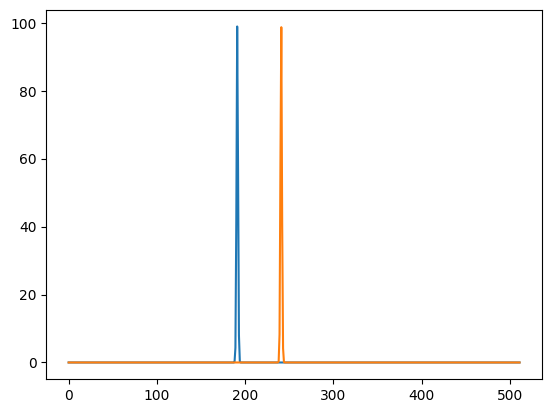

In [16]:
plt.plot(dist_train_y[10,:])
plt.plot(dist_train_y[50,:])

In [17]:
synth_train_y = dist_train_y.clone()
synth_train_x =       data_x.clone()

In [18]:
for sigma in np.arange(0.00, 20*base_sigma, base_sigma):
    print(f"{sigma:0.6f}", end="\r")
    
    w = torch.randn(data_x.shape)*sigma

    synth_train_x = torch.concatenate(
        (synth_train_x, data_x + w),
        dim = 0
    )

    dist_train_y = target_distribution(data_y, a, b, num_classes, base_sigma + sigma)

    synth_train_y = torch.concatenate(
        (synth_train_y, dist_train_y),
        dim = 0
    )

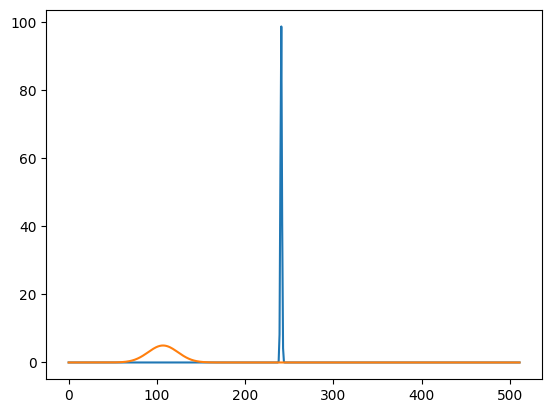

In [19]:
plt.plot(synth_train_y[50,:])
plt.plot(synth_train_y[synth_train_y.shape[0]-1,:])

In [20]:
device = torch.device("cuda:0")
synth_train_x = synth_train_x.to(device)
synth_train_y = synth_train_y.to(device)

In [71]:
# Taken from: https://pyimagesearch.com/2021/07/19/pytorch-training-your-first-convolutional-neural-network-cnn/
class LeNet(nn.Module):
    
    def __init__(self, num_channels, hist_size, classes):
        # call the parent constructor
        super(LeNet, self).__init__()
        
        # initializefirst set of CONV => RELU => POOL layers
        self.conv1 = nn.Conv1d(
            in_channels=num_channels, out_channels=20,
            kernel_size=5
        )
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # initialize second set of CONV => RELU => POOL layers
        self.conv2 = nn.Conv1d(
            in_channels=20, out_channels=50,
            kernel_size=5
        )
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # initialize first (and only) set of FC => RELU layers
        self.fc1 = nn.Linear(in_features=int(hist_size/4-3)*50, out_features=500)
        self.relu3 = nn.ReLU()
        
        # initialize our softmax classifier
        self.fc2 = nn.Linear(in_features=500, out_features=classes)
        self.log_softmax = nn.LogSoftmax(dim=1)
        self.softmax = nn.Softmax(dim=1)


    def forward(self, x):
        # pass the input through our first set of CONV => RELU =>
        # POOL layers
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        
        # pass the output from the previous layer through the second
        # set of CONV => RELU => POOL layers
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        
        # flatten the output from the previous layer and pass it
        # through our only set of FC => RELU layers
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu3(x)
        
        # pass the output to our softmax classifier to get our output
        # predictions
        x = self.fc2(x)
        output = self.log_softmax(x)
        # output = self.softmax(x)

        # return the output predictions
        return output

In [173]:
net = LeNet(num_channels=1, hist_size=seq_length, classes=num_classes)
net = net.to(device)

criterion = nn.CrossEntropyLoss()
losses = list()

y = net(synth_train_x)
y.shape

torch.Size([26628, 512])

In [174]:
num_epochs = int(1e5)
# optimizer = torch.optim.SGD(net.parameters(), lr=1e-4)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)

# Train the model
for epoch in range(num_epochs):
    outputs = net(synth_train_x)
    loss = criterion(outputs, synth_train_y)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.8f" % (epoch, loss.item()), end="\r")
    losses.append(loss.item())

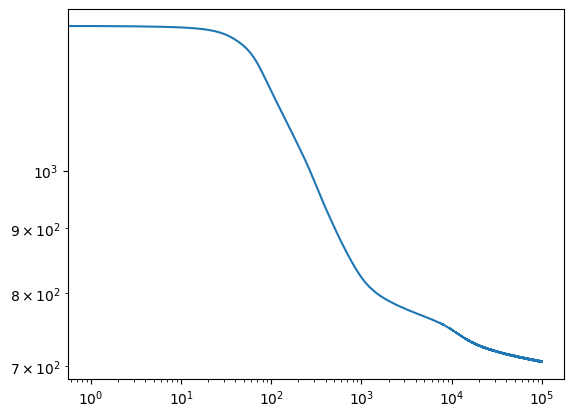

In [175]:
plt.loglog(losses)

In [176]:
predict = lambda x: torch.exp(net(x.to(device))).cpu().detach().numpy()
# predict = lambda x: net(x.to(device)).cpu().detach().numpy()

In [177]:
data_x.shape

torch.Size([1268, 1, 64])

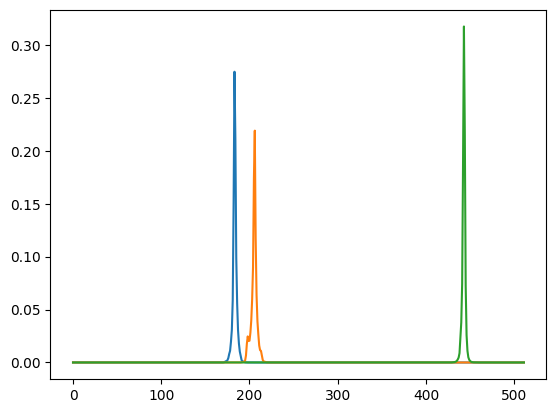

In [178]:
plt.plot(predict(synth_train_x[20,:].unsqueeze(0)).flatten())
plt.plot(predict(synth_train_x[200,:].unsqueeze(0)).flatten())
plt.plot(predict(synth_train_x[2000,:].unsqueeze(0)).flatten())

In [179]:
idx=1000

In [180]:
X_mean = data_x[idx].to(device).unsqueeze(0).clone()
X_stat = data_x[idx].to(device).unsqueeze(0).clone()

xt_mean = []
et_mean = []

xt_stat = []
et_stat = []

for i in range(400):
    # predict a trajectory based on the prediction mean
    # => the trajectory does not pick up artificial noise from the prediction
    # => there is no signature of uncertainty encoded in the trajectory
    Y = predict(X_mean)
    x, e = dist_stats(Y[0, :], a, b)
    X_mean = shuffle(X_mean, x)
    xt_mean.append(x)
    et_mean.append(e)

    # predict trajectory based on the prediction sample
    # => the trajectory's trajectory picks up noise from the prediction
    # => there is a signature encoding the prediction uncertainty
    Y = predict(X_stat)
    _, e = dist_stats(Y[0, :], a, b)
    xs = sample(Y, a, b)[0]
    X_stat = shuffle(X_stat, xs)
    xt_stat.append(xs)
    et_stat.append(e)
    
xt_mean = np.array(xt_mean)
et_mean = np.array(et_mean)
xt_stat = np.array(xt_stat)
et_stat = np.array(et_stat)

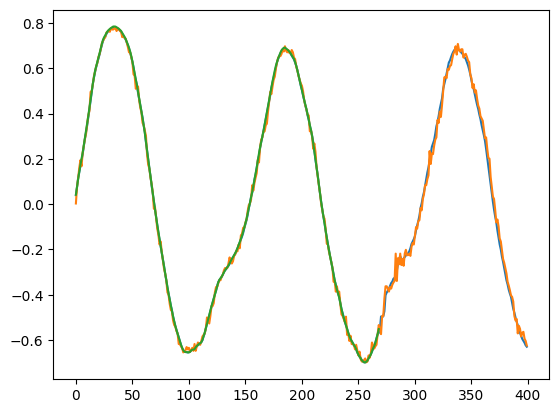

In [181]:
plt.plot(xt_mean)
plt.plot(xt_stat)
plt.plot(training_set[idx+64:idx+400+64, 0])

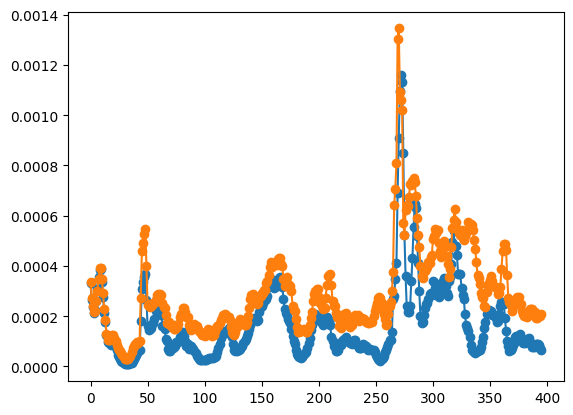

In [182]:
plt.plot(moving_average(et_mean, n=5), 'o-')
plt.plot(moving_average(et_stat, n=5), 'o-')

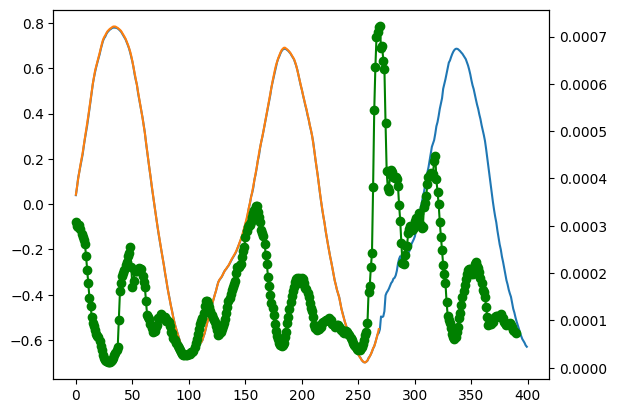

In [183]:
plt.plot(xt_mean)
plt.plot(training_set[idx+64:idx+400+64, 0])
plt.twinx()
plt.plot(moving_average(et_mean, n=11), 'go-')

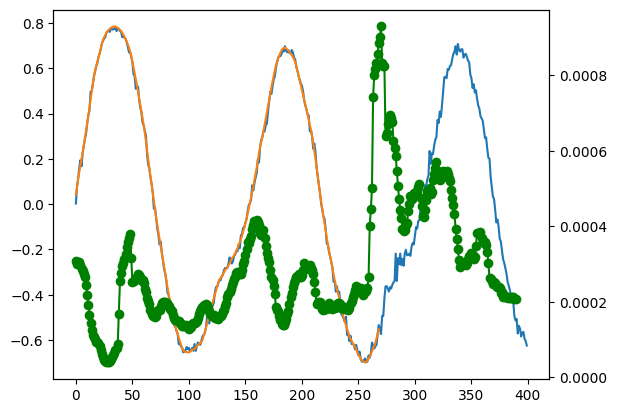

In [184]:
plt.plot(xt_stat)
plt.plot(training_set[idx+64:idx+400+64, 0])
plt.twinx()
plt.plot(moving_average(et_stat, n=11), 'go-')